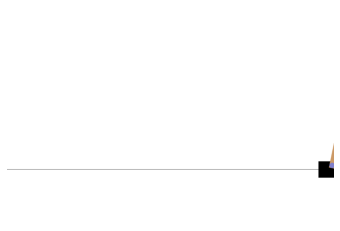

Episode 5 finished with total reward: 139.0


In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Define the Q-Network (a simple feedforward neural network)
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Function to select action based on epsilon-greedy policy
def select_action(state, policy_net, epsilon, action_dim):
    if random.random() > epsilon:  # Exploit
        with torch.no_grad():
            return policy_net(state).argmax().item()  # Choose action with highest Q-value
    else:  # Explore
        return random.choice(np.arange(action_dim))

# Function to optimize the model
def optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma):
    if len(memory) < batch_size:
        return

    # Sample a random minibatch of transitions from memory
    batch = random.sample(memory, batch_size)
    batch = list(zip(*batch))

    states = torch.tensor(np.vstack(batch[0]), dtype=torch.float32)
    actions = torch.tensor(batch[1], dtype=torch.long)
    rewards = torch.tensor(batch[2], dtype=torch.float32)
    next_states = torch.tensor(np.vstack(batch[3]), dtype=torch.float32)
    dones = torch.tensor(batch[4], dtype=torch.float32)

    # Compute Q-values for current states (policy network)
    q_values = policy_net(states).gather(1, actions.view(-1, 1)).squeeze()

    # Compute Q-values for next states (target network)
    next_q_values = target_net(next_states).max(1)[0]

    # Compute target Q-values
    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    # Compute loss (Mean Squared Error)
    loss = nn.MSELoss()(q_values, target_q_values)

    # Perform gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# DQN training function
def train_dqn(env, policy_net, target_net, optimizer, num_episodes, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, target_update_freq, memory_size):
    memory = deque(maxlen=memory_size)  # Experience replay buffer
    epsilon = epsilon_start
    scores = []

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        done = False
        total_reward = 0

        while not done:
            # Select action using epsilon-greedy strategy
            action = select_action(state, policy_net, epsilon, env.action_space.n)
            next_state, reward, done, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store transition in memory
            memory.append((state.numpy(), action, reward, next_state.numpy(), done))

            # Update state and total reward
            state = next_state
            total_reward += reward

            # Optimize the model
            optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma)

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Update the target network every few episodes
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Save total reward for tracking progress
        scores.append(total_reward)

        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.4f}")

    return scores

# Function to simulate the agent after training
def simulate_agent(env, policy_net, episodes=5):
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            # Render the environment
            img = env.render(mode='rgb_array')
            plt.imshow(img)
            plt.axis('off')
            clear_output(wait=True)
            plt.show()

            # Choose action
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action = policy_net(state).argmax().item()

            # Step the environment
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward

        print(f"Episode {episode+1} finished with total reward: {total_reward}")

    env.close()

# Main execution
env = gym.make('CartPole-v0')

# Set random seed for reproducibility
env.seed(42)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Initialize policy and target networks
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())  # Initialize target network with same weights
target_net.eval()  # Target network doesn't get updated during backpropagation

# Hyperparameters
gamma = 0.99  # Discount factor
epsilon_start = 1.0  # Initial epsilon value for epsilon-greedy strategy
epsilon_end = 0.01  # Minimum epsilon value
epsilon_decay = 0.995  # Epsilon decay rate
target_update_freq = 10  # Update target network every 10 episodes
num_episodes = 500  # Number of episodes for training
batch_size = 64  # Batch size for experience replay
memory_size = 10000  # Size of experience replay buffer
learning_rate = 0.001  # Learning rate

# Optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Train the agent using DQN
scores = train_dqn(env, policy_net, target_net, optimizer, num_episodes, batch_size, gamma, epsilon_start, epsilon_end, epsilon_decay, target_update_freq, memory_size)

# Plot the training progress
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN on CartPole-v0')
plt.show()

# Simulate the trained agent
simulate_agent(env, policy_net)
